In [83]:
import os
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F

In [84]:
raw = pd.read_csv('../data/BTC/BTC_Book_0.zip', compression = 'zip', parse_dates = True, index_col = 0)
prices = raw[raw.columns[1::3]]
sizes = raw[raw.columns[2::3]]
trades = raw[raw.columns[3::3]]

In [85]:
feature_data = pd.DataFrame((prices['Bid_1_Price'] + prices['Ask_1_Price'])/2, columns = ['Mid_Price'])
feature_data['Spread'] = prices['Ask_1_Price'] - prices['Bid_1_Price']
feature_data['Bid_Dist'] = prices['Bid_1_Price'] - prices['Bid_50_Price']
feature_data['Ask_Dist'] = prices['Ask_50_Price'] - prices['Ask_1_Price']

feature_data['Level_1_Size_IMB'] = sizes['Ask_1_Size'] - sizes['Bid_1_Size']
feature_data['Ask_1_Size'] = sizes['Ask_1_Size']
feature_data['Bid_1_Size'] = sizes['Bid_1_Size']

bid_sizes = sizes[sizes.columns[:50]]
feature_data['Cumu_Bids'] = bid_sizes.cumsum(axis=1)['Bid_50_Size']

ask_sizes = sizes[sizes.columns[50:]]
feature_data['Cumu_Asks'] = ask_sizes.cumsum(axis=1)['Ask_50_Size']

feature_data['Cumu_Size_IMB'] = feature_data['Cumu_Asks'] - feature_data['Cumu_Bids']

feature_data.head()

,Mid_Price,Spread,Bid_Dist,Ask_Dist,Level_1_Size_IMB,Ask_1_Size,Bid_1_Size,Cumu_Bids,Cumu_Asks,Cumu_Size_IMB
Timestamp,,,,,,,,,,
2020-04-03 17:06:34.424123-04:00,6708.695,0.01,28.69,34.36,0.747936,1.194986,0.447050,101.206556,89.55978,-11.646776
2020-04-03 17:06:35.388369-04:00,6708.695,0.01,28.69,34.36,0.778807,1.194986,0.416178,101.175685,89.55978,-11.615905
2020-04-03 17:06:36.414534-04:00,6708.695,0.01,28.69,34.36,0.778807,1.194986,0.416178,101.175685,89.55978,-11.615905
2020-04-03 17:06:37.400652-04:00,6708.695,0.01,28.69,34.36,0.778807,1.194986,0.416178,101.175685,89.55978,-11.615905
2020-04-03 17:06:38.408623-04:00,6708.695,0.01,28.69,34.36,0.778807,1.194986,0.416178,101.175685,89.55978,-11.615905


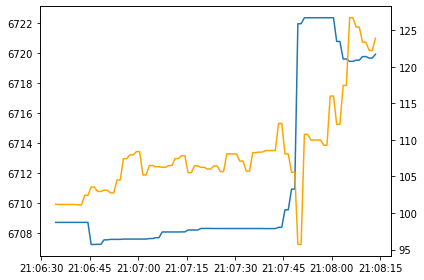

In [86]:
fig, ax1 = plt.subplots()
start = 0
window = 100

ax1.plot(feature_data['Mid_Price'][start:start+window])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(feature_data['Cumu_Bids'][start:start+window], c = 'orange')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

[ 6.67200500e+03  1.00000000e-02  6.29000000e+00  1.13100000e+01
 -2.53678015e+01  2.00000000e-08  1.60000000e-07  1.03265411e+01
  1.65309761e+01 -1.21542457e+02]


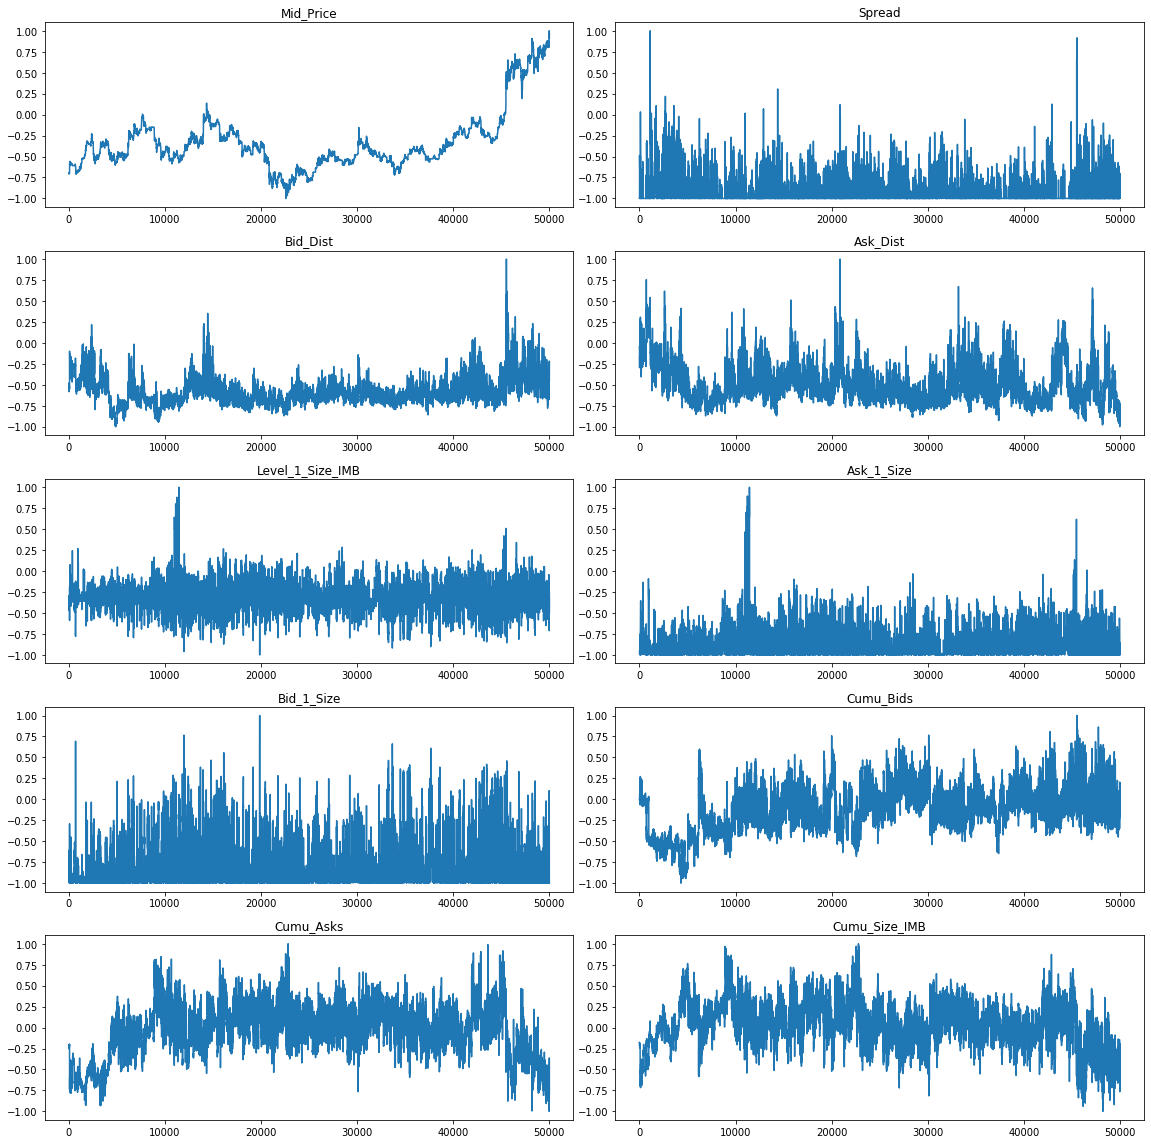

In [87]:
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler(feature_range=(-1, 1))


#mid_price_reshape = np.expand_dims(mid_price.values,1)
feature_scaler.fit(feature_data)
print(feature_scaler.data_min_)

feature_norm = feature_scaler.transform(feature_data)

fig, ax = plt.subplots(5,2, figsize = (16,16))

for i in range(5):
    for j in range(2):
        ax[i][j].plot(feature_norm[:,2*i+j])
        ax[i][j].set_title(feature_data.columns[2*i+j])
        
fig.tight_layout()

#check proper scaling with data_min_

In [88]:
def rolling_window(a, window_size):
    shape = (a.shape[0] - window_size + 1, window_size) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


subsets = rolling_window(feature_norm,100)
X = subsets[:len(subsets)-1]
Y = subsets[1:][:,-1,0]

X = torch.Tensor(X)
Y = torch.Tensor(np.expand_dims(Y,1))

print(X.shape)
print(Y.shape)

torch.Size([49900, 100, 10])
torch.Size([49900, 1])


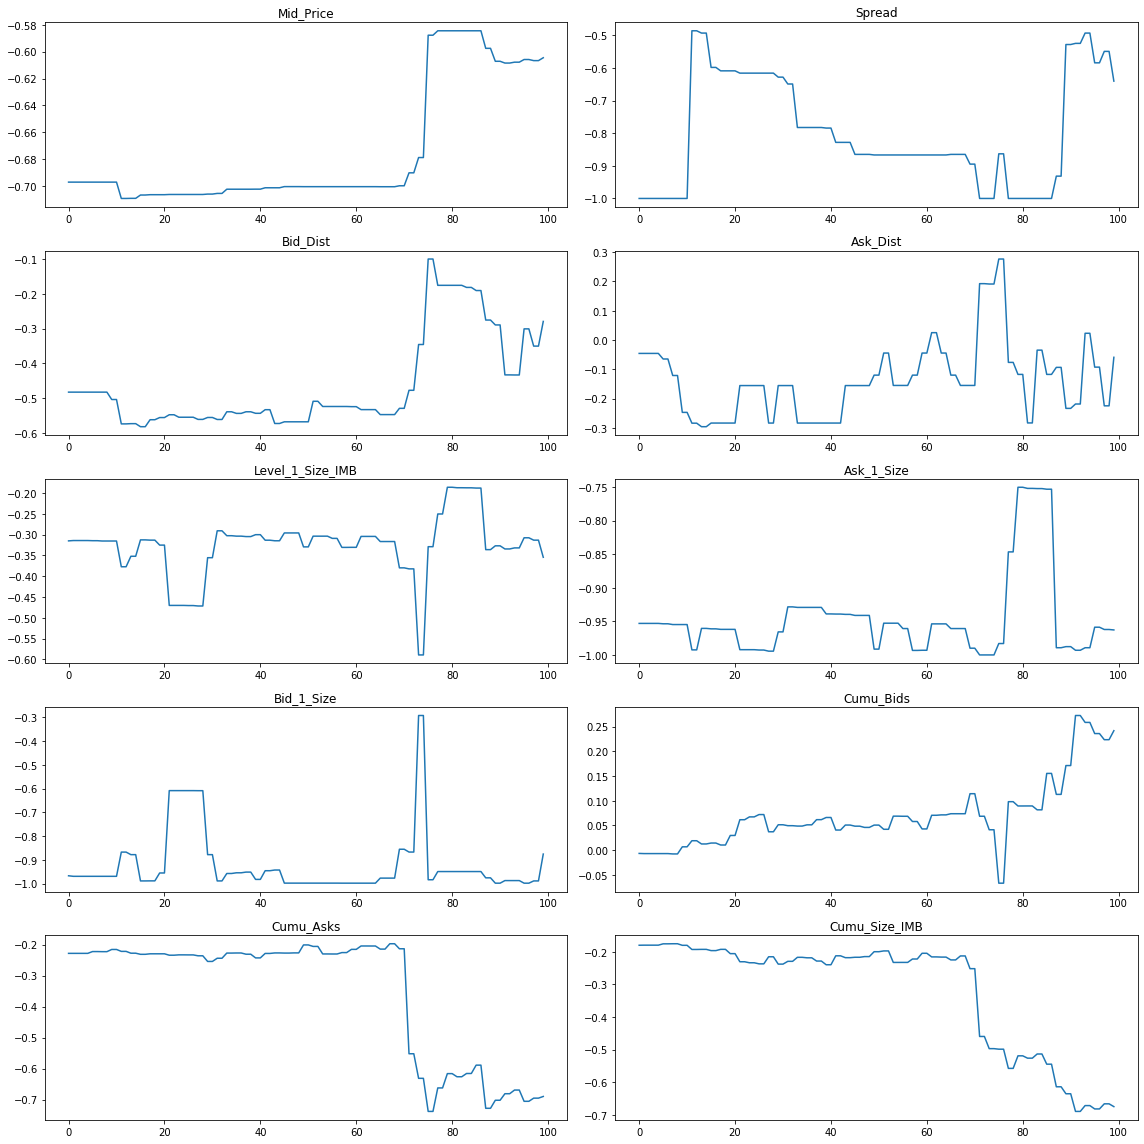

In [89]:
fig, ax = plt.subplots(5,2, figsize = (16,16))

for i in range(5):
    for j in range(2):
        ax[i][j].plot(X[0][:,2*i+j])
        ax[i][j].set_title(feature_data.columns[2*i+j])
        
fig.tight_layout()

In [99]:
class RecurrentModel(nn.Module):
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE):
        super(RecurrentModel, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size = INPUT_SIZE,
            hidden_size = HIDDEN_SIZE, # number of hidden units
            num_layers = N_LAYERS, # number of layers
            batch_first = True
        )
        
        self.out = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
            
    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        # r_out, (h_n, h_c) = self.rnn(x, None) # None represents zero initial hidden state
            
        r_out, h = self.lstm(x, None) # None represents zero initial hidden state
            
        # to choose last time step of output, use -1 in center index
            
        out = self.out(r_out[:, -1, :])
        return out

    
n_hidden = 20
price_model = RecurrentModel(10, n_hidden, 1, 1)
return_model = RecurrentModel(10, n_hidden, 1, 1)

In [100]:
def train_model(model, LR, n_epochs, X_BATCH, Y_BATCH):
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)   # optimize all rnn parameters
    loss_func = nn.MSELoss()  

    all_losses = []
    all_accuracies = []

    for epoch in range(1,n_epochs+1):
        if epoch % 4 == 0:
            for param in optimizer.param_groups:
                param['lr'] = param['lr']/2 

        for i in range(len(X_BATCH)):

            train_x = X_BATCH[i]
            train_y = Y_BATCH[i]

            output = model(train_x)
            loss = loss_func(output, train_y)                # compute loss                      
            optimizer.zero_grad()                            # clear gradients for this training step
            loss.backward()                                  # backpropagation, compute gradients
            optimizer.step()                                 # apply gradient step

            all_losses.append(loss.item())                   #track loss

    #     #compute accuracy
    #     acc_output = rnn(b_x)
    #     pred_y = torch.max(acc_output,1)[1].data.numpy().squeeze()
    #     target = torch.max(b_y,1)[1].data.numpy().squeeze()
    #     train_accuracy = sum(pred_y==target)/b_y.size(0)

            #print info
            print("Epoch: ", epoch, "| train loss: %.4f" % loss.item())#, "| train accuracy: %.8f" % train_accuracy)

    return all_losses, all_accuracies

Epoch:  1 | train loss: 0.5026
Epoch:  1 | train loss: 0.0058
Epoch:  1 | train loss: 0.0679
Epoch:  1 | train loss: 0.0108
Epoch:  1 | train loss: 0.0289
Epoch:  1 | train loss: 0.0411
Epoch:  1 | train loss: 0.0205
Epoch:  1 | train loss: 0.0600
Epoch:  1 | train loss: 0.0037
Epoch:  1 | train loss: 0.0089
Epoch:  1 | train loss: 0.0012
Epoch:  1 | train loss: 0.0057
Epoch:  1 | train loss: 0.0359
Epoch:  1 | train loss: 0.0386
Epoch:  1 | train loss: 0.0179
Epoch:  1 | train loss: 0.0169
Epoch:  1 | train loss: 0.0044
Epoch:  1 | train loss: 0.0362
Epoch:  1 | train loss: 0.1258
Epoch:  1 | train loss: 0.1884
Epoch:  1 | train loss: 0.1074
Epoch:  1 | train loss: 0.0788
Epoch:  1 | train loss: 0.0173
Epoch:  1 | train loss: 0.0017
Epoch:  1 | train loss: 0.0628
Epoch:  1 | train loss: 0.1720
Epoch:  1 | train loss: 0.1286
Epoch:  1 | train loss: 0.1253
Epoch:  1 | train loss: 0.2620
Epoch:  1 | train loss: 0.1159
Epoch:  1 | train loss: 0.0526
Epoch:  1 | train loss: 0.0065
Epoch:  

Epoch:  3 | train loss: 0.0197
Epoch:  3 | train loss: 0.0086
Epoch:  3 | train loss: 0.0026
Epoch:  3 | train loss: 0.0028
Epoch:  3 | train loss: 0.0031
Epoch:  3 | train loss: 0.0103
Epoch:  3 | train loss: 0.0223
Epoch:  3 | train loss: 0.0185
Epoch:  3 | train loss: 0.0180
Epoch:  3 | train loss: 0.0011
Epoch:  3 | train loss: 0.0002
Epoch:  3 | train loss: 0.0001
Epoch:  3 | train loss: 0.0067
Epoch:  3 | train loss: 0.0183
Epoch:  3 | train loss: 0.0212
Epoch:  3 | train loss: 0.0600
Epoch:  3 | train loss: 0.0774
Epoch:  3 | train loss: 0.0460
Epoch:  3 | train loss: 0.0788
Epoch:  3 | train loss: 0.0988
Epoch:  3 | train loss: 0.0809
Epoch:  3 | train loss: 0.0183
Epoch:  3 | train loss: 0.0070
Epoch:  3 | train loss: 0.0008
Epoch:  3 | train loss: 0.0282
Epoch:  3 | train loss: 0.0808
Epoch:  3 | train loss: 0.5128
Epoch:  3 | train loss: 0.6217
Epoch:  3 | train loss: 0.5736
Epoch:  3 | train loss: 0.2961
Epoch:  3 | train loss: 0.2735
Epoch:  3 | train loss: 0.1388
Epoch:  

Epoch:  6 | train loss: 0.0178
Epoch:  6 | train loss: 0.0076
Epoch:  6 | train loss: 0.0051
Epoch:  6 | train loss: 0.0074
Epoch:  6 | train loss: 0.0090
Epoch:  6 | train loss: 0.0027
Epoch:  6 | train loss: 0.0054
Epoch:  6 | train loss: 0.0072
Epoch:  6 | train loss: 0.0057
Epoch:  6 | train loss: 0.0174
Epoch:  6 | train loss: 0.0264
Epoch:  6 | train loss: 0.0681
Epoch:  6 | train loss: 0.1421
Epoch:  6 | train loss: 0.1321
Epoch:  6 | train loss: 0.1585
Epoch:  6 | train loss: 0.1897
Epoch:  6 | train loss: 0.1229
Epoch:  6 | train loss: 0.0708
Epoch:  6 | train loss: 0.0452
Epoch:  6 | train loss: 0.0544
Epoch:  6 | train loss: 0.0407
Epoch:  6 | train loss: 0.0059
Epoch:  6 | train loss: 0.0080
Epoch:  6 | train loss: 0.0110
Epoch:  6 | train loss: 0.0148
Epoch:  6 | train loss: 0.0222
Epoch:  6 | train loss: 0.0047
Epoch:  6 | train loss: 0.0117
Epoch:  6 | train loss: 0.0053
Epoch:  6 | train loss: 0.0064
Epoch:  6 | train loss: 0.0686
Epoch:  6 | train loss: 0.0495
Epoch:  

Epoch:  8 | train loss: 0.0050
Epoch:  8 | train loss: 0.0033
Epoch:  8 | train loss: 0.0095
Epoch:  8 | train loss: 0.0103
Epoch:  8 | train loss: 0.0187
Epoch:  9 | train loss: 0.0035
Epoch:  9 | train loss: 0.0136
Epoch:  9 | train loss: 0.0033
Epoch:  9 | train loss: 0.0235
Epoch:  9 | train loss: 0.0272
Epoch:  9 | train loss: 0.0010
Epoch:  9 | train loss: 0.0185
Epoch:  9 | train loss: 0.0235
Epoch:  9 | train loss: 0.0034
Epoch:  9 | train loss: 0.0018
Epoch:  9 | train loss: 0.0014
Epoch:  9 | train loss: 0.0019
Epoch:  9 | train loss: 0.0102
Epoch:  9 | train loss: 0.0018
Epoch:  9 | train loss: 0.0037
Epoch:  9 | train loss: 0.0015
Epoch:  9 | train loss: 0.0015
Epoch:  9 | train loss: 0.0021
Epoch:  9 | train loss: 0.0020
Epoch:  9 | train loss: 0.0043
Epoch:  9 | train loss: 0.0074
Epoch:  9 | train loss: 0.0031
Epoch:  9 | train loss: 0.0049
Epoch:  9 | train loss: 0.0051
Epoch:  9 | train loss: 0.0043
Epoch:  9 | train loss: 0.0062
Epoch:  9 | train loss: 0.0048
Epoch:  

Epoch:  11 | train loss: 0.0009
Epoch:  11 | train loss: 0.0008
Epoch:  11 | train loss: 0.0003
Epoch:  11 | train loss: 0.0002
Epoch:  11 | train loss: 0.0014
Epoch:  11 | train loss: 0.0195
Epoch:  11 | train loss: 0.0152
Epoch:  11 | train loss: 0.0080
Epoch:  11 | train loss: 0.0050
Epoch:  11 | train loss: 0.0057
Epoch:  11 | train loss: 0.0053
Epoch:  11 | train loss: 0.0039
Epoch:  11 | train loss: 0.0015
Epoch:  11 | train loss: 0.0013
Epoch:  11 | train loss: 0.0014
Epoch:  11 | train loss: 0.0056
Epoch:  11 | train loss: 0.0067
Epoch:  11 | train loss: 0.0048
Epoch:  11 | train loss: 0.0041
Epoch:  11 | train loss: 0.0007
Epoch:  11 | train loss: 0.0014
Epoch:  11 | train loss: 0.0012
Epoch:  11 | train loss: 0.0027
Epoch:  11 | train loss: 0.0013
Epoch:  11 | train loss: 0.0007
Epoch:  11 | train loss: 0.0014
Epoch:  11 | train loss: 0.0024
Epoch:  11 | train loss: 0.0009
Epoch:  11 | train loss: 0.0038
Epoch:  11 | train loss: 0.0039
Epoch:  11 | train loss: 0.0036
Epoch:  

Epoch:  14 | train loss: 0.0077
Epoch:  14 | train loss: 0.0057
Epoch:  14 | train loss: 0.0092
Epoch:  14 | train loss: 0.0042
Epoch:  14 | train loss: 0.0050
Epoch:  14 | train loss: 0.0029
Epoch:  14 | train loss: 0.0017
Epoch:  14 | train loss: 0.0026
Epoch:  14 | train loss: 0.0029
Epoch:  14 | train loss: 0.0019
Epoch:  14 | train loss: 0.0036
Epoch:  14 | train loss: 0.0015
Epoch:  14 | train loss: 0.0028
Epoch:  14 | train loss: 0.0033
Epoch:  14 | train loss: 0.0022
Epoch:  14 | train loss: 0.0013
Epoch:  14 | train loss: 0.0011
Epoch:  14 | train loss: 0.0016
Epoch:  14 | train loss: 0.0017
Epoch:  14 | train loss: 0.0088
Epoch:  14 | train loss: 0.0060
Epoch:  14 | train loss: 0.0013
Epoch:  14 | train loss: 0.0025
Epoch:  14 | train loss: 0.0014
Epoch:  14 | train loss: 0.0005
Epoch:  14 | train loss: 0.0007
Epoch:  14 | train loss: 0.0010
Epoch:  14 | train loss: 0.0020
Epoch:  14 | train loss: 0.0015
Epoch:  14 | train loss: 0.0054
Epoch:  14 | train loss: 0.0247
Epoch:  

Epoch:  16 | train loss: 0.0010
Epoch:  16 | train loss: 0.0035
Epoch:  16 | train loss: 0.0032
Epoch:  16 | train loss: 0.0028
Epoch:  16 | train loss: 0.0027
Epoch:  16 | train loss: 0.0007
Epoch:  16 | train loss: 0.0020
Epoch:  16 | train loss: 0.0023
Epoch:  16 | train loss: 0.0036
Epoch:  16 | train loss: 0.0028
Epoch:  16 | train loss: 0.0015
Epoch:  16 | train loss: 0.0007
Epoch:  16 | train loss: 0.0004
Epoch:  16 | train loss: 0.0009
Epoch:  16 | train loss: 0.0003
Epoch:  16 | train loss: 0.0002
Epoch:  16 | train loss: 0.0012
Epoch:  16 | train loss: 0.0052
Epoch:  16 | train loss: 0.0100
Epoch:  16 | train loss: 0.0144
Epoch:  16 | train loss: 0.0018
Epoch:  16 | train loss: 0.0009
Epoch:  16 | train loss: 0.0040
Epoch:  16 | train loss: 0.0019
Epoch:  16 | train loss: 0.0005
Epoch:  16 | train loss: 0.0021
Epoch:  16 | train loss: 0.0008
Epoch:  16 | train loss: 0.0022
Epoch:  16 | train loss: 0.0013
Epoch:  16 | train loss: 0.0028
Epoch:  16 | train loss: 0.0086
Epoch:  

Epoch:  19 | train loss: 0.0007
Epoch:  19 | train loss: 0.0006
Epoch:  19 | train loss: 0.0009
Epoch:  19 | train loss: 0.0002
Epoch:  19 | train loss: 0.0003
Epoch:  19 | train loss: 0.0039
Epoch:  19 | train loss: 0.0026
Epoch:  19 | train loss: 0.0003
Epoch:  19 | train loss: 0.0009
Epoch:  19 | train loss: 0.0008
Epoch:  19 | train loss: 0.0005
Epoch:  19 | train loss: 0.0007
Epoch:  19 | train loss: 0.0009
Epoch:  19 | train loss: 0.0011
Epoch:  19 | train loss: 0.0013
Epoch:  19 | train loss: 0.0023
Epoch:  19 | train loss: 0.0128
Epoch:  19 | train loss: 0.0143
Epoch:  19 | train loss: 0.0165
Epoch:  19 | train loss: 0.0264
Epoch:  19 | train loss: 0.0172
Epoch:  19 | train loss: 0.0085
Epoch:  19 | train loss: 0.0057
Epoch:  19 | train loss: 0.0094
Epoch:  19 | train loss: 0.0099
Epoch:  19 | train loss: 0.0019
Epoch:  19 | train loss: 0.0003
Epoch:  19 | train loss: 0.0004
Epoch:  19 | train loss: 0.0002
Epoch:  19 | train loss: 0.0005
Epoch:  19 | train loss: 0.0007
Epoch:  

Epoch:  21 | train loss: 0.0002
Epoch:  21 | train loss: 0.0001
Epoch:  21 | train loss: 0.0007
Epoch:  21 | train loss: 0.0029
Epoch:  21 | train loss: 0.0067
Epoch:  21 | train loss: 0.0109
Epoch:  21 | train loss: 0.0014
Epoch:  21 | train loss: 0.0007
Epoch:  21 | train loss: 0.0039
Epoch:  21 | train loss: 0.0022
Epoch:  21 | train loss: 0.0009
Epoch:  21 | train loss: 0.0022
Epoch:  21 | train loss: 0.0010
Epoch:  21 | train loss: 0.0014
Epoch:  21 | train loss: 0.0006
Epoch:  21 | train loss: 0.0017
Epoch:  21 | train loss: 0.0065
Epoch:  22 | train loss: 0.0015
Epoch:  22 | train loss: 0.0008
Epoch:  22 | train loss: 0.0023
Epoch:  22 | train loss: 0.0096
Epoch:  22 | train loss: 0.0063
Epoch:  22 | train loss: 0.0052
Epoch:  22 | train loss: 0.0073
Epoch:  22 | train loss: 0.0061
Epoch:  22 | train loss: 0.0038
Epoch:  22 | train loss: 0.0006
Epoch:  22 | train loss: 0.0012
Epoch:  22 | train loss: 0.0015
Epoch:  22 | train loss: 0.0008
Epoch:  22 | train loss: 0.0008
Epoch:  

Epoch:  24 | train loss: 0.0015
Epoch:  24 | train loss: 0.0017
Epoch:  24 | train loss: 0.0070
Epoch:  24 | train loss: 0.0080
Epoch:  24 | train loss: 0.0075
Epoch:  24 | train loss: 0.0146
Epoch:  24 | train loss: 0.0110
Epoch:  24 | train loss: 0.0061
Epoch:  24 | train loss: 0.0043
Epoch:  24 | train loss: 0.0065
Epoch:  24 | train loss: 0.0076
Epoch:  24 | train loss: 0.0021
Epoch:  24 | train loss: 0.0005
Epoch:  24 | train loss: 0.0005
Epoch:  24 | train loss: 0.0003
Epoch:  24 | train loss: 0.0007
Epoch:  24 | train loss: 0.0015
Epoch:  24 | train loss: 0.0021
Epoch:  24 | train loss: 0.0020
Epoch:  24 | train loss: 0.0009
Epoch:  24 | train loss: 0.0007
Epoch:  24 | train loss: 0.0005
Epoch:  24 | train loss: 0.0004
Epoch:  24 | train loss: 0.0005
Epoch:  24 | train loss: 0.0011
Epoch:  24 | train loss: 0.0005
Epoch:  24 | train loss: 0.0013
Epoch:  24 | train loss: 0.0014
Epoch:  24 | train loss: 0.0014
Epoch:  24 | train loss: 0.0008
Epoch:  24 | train loss: 0.0014
Epoch:  

Epoch:  26 | train loss: 0.0006
Epoch:  26 | train loss: 0.0015
Epoch:  26 | train loss: 0.0059
Epoch:  27 | train loss: 0.0016
Epoch:  27 | train loss: 0.0012
Epoch:  27 | train loss: 0.0021
Epoch:  27 | train loss: 0.0070
Epoch:  27 | train loss: 0.0043
Epoch:  27 | train loss: 0.0047
Epoch:  27 | train loss: 0.0056
Epoch:  27 | train loss: 0.0046
Epoch:  27 | train loss: 0.0032
Epoch:  27 | train loss: 0.0005
Epoch:  27 | train loss: 0.0008
Epoch:  27 | train loss: 0.0010
Epoch:  27 | train loss: 0.0004
Epoch:  27 | train loss: 0.0004
Epoch:  27 | train loss: 0.0011
Epoch:  27 | train loss: 0.0008
Epoch:  27 | train loss: 0.0008
Epoch:  27 | train loss: 0.0005
Epoch:  27 | train loss: 0.0008
Epoch:  27 | train loss: 0.0011
Epoch:  27 | train loss: 0.0009
Epoch:  27 | train loss: 0.0027
Epoch:  27 | train loss: 0.0067
Epoch:  27 | train loss: 0.0008
Epoch:  27 | train loss: 0.0011
Epoch:  27 | train loss: 0.0010
Epoch:  27 | train loss: 0.0005
Epoch:  27 | train loss: 0.0005
Epoch:  

Epoch:  29 | train loss: 0.0002
Epoch:  29 | train loss: 0.0006
Epoch:  29 | train loss: 0.0010
Epoch:  29 | train loss: 0.0017
Epoch:  29 | train loss: 0.0016
Epoch:  29 | train loss: 0.0007
Epoch:  29 | train loss: 0.0006
Epoch:  29 | train loss: 0.0004
Epoch:  29 | train loss: 0.0004
Epoch:  29 | train loss: 0.0006
Epoch:  29 | train loss: 0.0010
Epoch:  29 | train loss: 0.0004
Epoch:  29 | train loss: 0.0011
Epoch:  29 | train loss: 0.0013
Epoch:  29 | train loss: 0.0014
Epoch:  29 | train loss: 0.0007
Epoch:  29 | train loss: 0.0012
Epoch:  29 | train loss: 0.0005
Epoch:  29 | train loss: 0.0006
Epoch:  29 | train loss: 0.0005
Epoch:  29 | train loss: 0.0008
Epoch:  29 | train loss: 0.0009
Epoch:  29 | train loss: 0.0011
Epoch:  29 | train loss: 0.0015
Epoch:  29 | train loss: 0.0009
Epoch:  29 | train loss: 0.0005
Epoch:  29 | train loss: 0.0002
Epoch:  29 | train loss: 0.0003
Epoch:  29 | train loss: 0.0002
Epoch:  29 | train loss: 0.0003
Epoch:  29 | train loss: 0.0002
Epoch:  

Epoch:  32 | train loss: 0.0007
Epoch:  32 | train loss: 0.0004
Epoch:  32 | train loss: 0.0003
Epoch:  32 | train loss: 0.0007
Epoch:  32 | train loss: 0.0005
Epoch:  32 | train loss: 0.0005
Epoch:  32 | train loss: 0.0004
Epoch:  32 | train loss: 0.0007
Epoch:  32 | train loss: 0.0010
Epoch:  32 | train loss: 0.0007
Epoch:  32 | train loss: 0.0028
Epoch:  32 | train loss: 0.0066
Epoch:  32 | train loss: 0.0007
Epoch:  32 | train loss: 0.0013
Epoch:  32 | train loss: 0.0010
Epoch:  32 | train loss: 0.0005
Epoch:  32 | train loss: 0.0004
Epoch:  32 | train loss: 0.0008
Epoch:  32 | train loss: 0.0002
Epoch:  32 | train loss: 0.0002
Epoch:  32 | train loss: 0.0025
Epoch:  32 | train loss: 0.0018
Epoch:  32 | train loss: 0.0003
Epoch:  32 | train loss: 0.0005
Epoch:  32 | train loss: 0.0007
Epoch:  32 | train loss: 0.0006
Epoch:  32 | train loss: 0.0004
Epoch:  32 | train loss: 0.0008
Epoch:  32 | train loss: 0.0006
Epoch:  32 | train loss: 0.0017
Epoch:  32 | train loss: 0.0018
Epoch:  

Epoch:  34 | train loss: 0.0014
Epoch:  34 | train loss: 0.0007
Epoch:  34 | train loss: 0.0010
Epoch:  34 | train loss: 0.0004
Epoch:  34 | train loss: 0.0005
Epoch:  34 | train loss: 0.0005
Epoch:  34 | train loss: 0.0009
Epoch:  34 | train loss: 0.0008
Epoch:  34 | train loss: 0.0010
Epoch:  34 | train loss: 0.0013
Epoch:  34 | train loss: 0.0008
Epoch:  34 | train loss: 0.0004
Epoch:  34 | train loss: 0.0002
Epoch:  34 | train loss: 0.0003
Epoch:  34 | train loss: 0.0002
Epoch:  34 | train loss: 0.0003
Epoch:  34 | train loss: 0.0003
Epoch:  34 | train loss: 0.0005
Epoch:  34 | train loss: 0.0009
Epoch:  34 | train loss: 0.0029
Epoch:  34 | train loss: 0.0056
Epoch:  34 | train loss: 0.0008
Epoch:  34 | train loss: 0.0007
Epoch:  34 | train loss: 0.0023
Epoch:  34 | train loss: 0.0013
Epoch:  34 | train loss: 0.0010
Epoch:  34 | train loss: 0.0018
Epoch:  34 | train loss: 0.0008
Epoch:  34 | train loss: 0.0013
Epoch:  34 | train loss: 0.0005
Epoch:  34 | train loss: 0.0013
Epoch:  

Epoch:  37 | train loss: 0.0010
Epoch:  37 | train loss: 0.0005
Epoch:  37 | train loss: 0.0004
Epoch:  37 | train loss: 0.0008
Epoch:  37 | train loss: 0.0002
Epoch:  37 | train loss: 0.0002
Epoch:  37 | train loss: 0.0023
Epoch:  37 | train loss: 0.0017
Epoch:  37 | train loss: 0.0003
Epoch:  37 | train loss: 0.0004
Epoch:  37 | train loss: 0.0007
Epoch:  37 | train loss: 0.0006
Epoch:  37 | train loss: 0.0004
Epoch:  37 | train loss: 0.0008
Epoch:  37 | train loss: 0.0006
Epoch:  37 | train loss: 0.0017
Epoch:  37 | train loss: 0.0018
Epoch:  37 | train loss: 0.0032
Epoch:  37 | train loss: 0.0035
Epoch:  37 | train loss: 0.0029
Epoch:  37 | train loss: 0.0075
Epoch:  37 | train loss: 0.0058
Epoch:  37 | train loss: 0.0032
Epoch:  37 | train loss: 0.0021
Epoch:  37 | train loss: 0.0033
Epoch:  37 | train loss: 0.0043
Epoch:  37 | train loss: 0.0011
Epoch:  37 | train loss: 0.0004
Epoch:  37 | train loss: 0.0004
Epoch:  37 | train loss: 0.0002
Epoch:  37 | train loss: 0.0005
Epoch:  

Epoch:  39 | train loss: 0.0003
Epoch:  39 | train loss: 0.0003
Epoch:  39 | train loss: 0.0003
Epoch:  39 | train loss: 0.0005
Epoch:  39 | train loss: 0.0008
Epoch:  39 | train loss: 0.0026
Epoch:  39 | train loss: 0.0052
Epoch:  39 | train loss: 0.0007
Epoch:  39 | train loss: 0.0007
Epoch:  39 | train loss: 0.0022
Epoch:  39 | train loss: 0.0012
Epoch:  39 | train loss: 0.0010
Epoch:  39 | train loss: 0.0018
Epoch:  39 | train loss: 0.0008
Epoch:  39 | train loss: 0.0013
Epoch:  39 | train loss: 0.0005
Epoch:  39 | train loss: 0.0013
Epoch:  39 | train loss: 0.0053
Epoch:  40 | train loss: 0.0013
Epoch:  40 | train loss: 0.0012
Epoch:  40 | train loss: 0.0017
Epoch:  40 | train loss: 0.0049
Epoch:  40 | train loss: 0.0026
Epoch:  40 | train loss: 0.0039
Epoch:  40 | train loss: 0.0041
Epoch:  40 | train loss: 0.0033
Epoch:  40 | train loss: 0.0024
Epoch:  40 | train loss: 0.0005
Epoch:  40 | train loss: 0.0006
Epoch:  40 | train loss: 0.0008
Epoch:  40 | train loss: 0.0004
Epoch:  

Epoch:  42 | train loss: 0.0006
Epoch:  42 | train loss: 0.0017
Epoch:  42 | train loss: 0.0018
Epoch:  42 | train loss: 0.0030
Epoch:  42 | train loss: 0.0033
Epoch:  42 | train loss: 0.0027
Epoch:  42 | train loss: 0.0072
Epoch:  42 | train loss: 0.0055
Epoch:  42 | train loss: 0.0031
Epoch:  42 | train loss: 0.0020
Epoch:  42 | train loss: 0.0031
Epoch:  42 | train loss: 0.0041
Epoch:  42 | train loss: 0.0011
Epoch:  42 | train loss: 0.0004
Epoch:  42 | train loss: 0.0004
Epoch:  42 | train loss: 0.0002
Epoch:  42 | train loss: 0.0005
Epoch:  42 | train loss: 0.0008
Epoch:  42 | train loss: 0.0013
Epoch:  42 | train loss: 0.0013
Epoch:  42 | train loss: 0.0006
Epoch:  42 | train loss: 0.0006
Epoch:  42 | train loss: 0.0004
Epoch:  42 | train loss: 0.0004
Epoch:  42 | train loss: 0.0006
Epoch:  42 | train loss: 0.0009
Epoch:  42 | train loss: 0.0004
Epoch:  42 | train loss: 0.0010
Epoch:  42 | train loss: 0.0012
Epoch:  42 | train loss: 0.0013
Epoch:  42 | train loss: 0.0007
Epoch:  

Epoch:  44 | train loss: 0.0013
Epoch:  44 | train loss: 0.0005
Epoch:  44 | train loss: 0.0012
Epoch:  44 | train loss: 0.0052
Epoch:  45 | train loss: 0.0013
Epoch:  45 | train loss: 0.0011
Epoch:  45 | train loss: 0.0016
Epoch:  45 | train loss: 0.0047
Epoch:  45 | train loss: 0.0025
Epoch:  45 | train loss: 0.0038
Epoch:  45 | train loss: 0.0039
Epoch:  45 | train loss: 0.0032
Epoch:  45 | train loss: 0.0023
Epoch:  45 | train loss: 0.0005
Epoch:  45 | train loss: 0.0006
Epoch:  45 | train loss: 0.0008
Epoch:  45 | train loss: 0.0004
Epoch:  45 | train loss: 0.0003
Epoch:  45 | train loss: 0.0007
Epoch:  45 | train loss: 0.0005
Epoch:  45 | train loss: 0.0005
Epoch:  45 | train loss: 0.0004
Epoch:  45 | train loss: 0.0006
Epoch:  45 | train loss: 0.0009
Epoch:  45 | train loss: 0.0006
Epoch:  45 | train loss: 0.0026
Epoch:  45 | train loss: 0.0059
Epoch:  45 | train loss: 0.0007
Epoch:  45 | train loss: 0.0012
Epoch:  45 | train loss: 0.0009
Epoch:  45 | train loss: 0.0004
Epoch:  

Epoch:  47 | train loss: 0.0003
Epoch:  47 | train loss: 0.0002
Epoch:  47 | train loss: 0.0005
Epoch:  47 | train loss: 0.0007
Epoch:  47 | train loss: 0.0013
Epoch:  47 | train loss: 0.0013
Epoch:  47 | train loss: 0.0006
Epoch:  47 | train loss: 0.0006
Epoch:  47 | train loss: 0.0004
Epoch:  47 | train loss: 0.0004
Epoch:  47 | train loss: 0.0006
Epoch:  47 | train loss: 0.0008
Epoch:  47 | train loss: 0.0004
Epoch:  47 | train loss: 0.0009
Epoch:  47 | train loss: 0.0011
Epoch:  47 | train loss: 0.0013
Epoch:  47 | train loss: 0.0006
Epoch:  47 | train loss: 0.0009
Epoch:  47 | train loss: 0.0004
Epoch:  47 | train loss: 0.0005
Epoch:  47 | train loss: 0.0004
Epoch:  47 | train loss: 0.0009
Epoch:  47 | train loss: 0.0007
Epoch:  47 | train loss: 0.0009
Epoch:  47 | train loss: 0.0012
Epoch:  47 | train loss: 0.0008
Epoch:  47 | train loss: 0.0004
Epoch:  47 | train loss: 0.0003
Epoch:  47 | train loss: 0.0003
Epoch:  47 | train loss: 0.0003
Epoch:  47 | train loss: 0.0004
Epoch:  

Epoch:  50 | train loss: 0.0006
Epoch:  50 | train loss: 0.0008
Epoch:  50 | train loss: 0.0004
Epoch:  50 | train loss: 0.0003
Epoch:  50 | train loss: 0.0007
Epoch:  50 | train loss: 0.0005
Epoch:  50 | train loss: 0.0005
Epoch:  50 | train loss: 0.0004
Epoch:  50 | train loss: 0.0006
Epoch:  50 | train loss: 0.0009
Epoch:  50 | train loss: 0.0006
Epoch:  50 | train loss: 0.0025
Epoch:  50 | train loss: 0.0058
Epoch:  50 | train loss: 0.0007
Epoch:  50 | train loss: 0.0012
Epoch:  50 | train loss: 0.0009
Epoch:  50 | train loss: 0.0004
Epoch:  50 | train loss: 0.0004
Epoch:  50 | train loss: 0.0008
Epoch:  50 | train loss: 0.0002
Epoch:  50 | train loss: 0.0002
Epoch:  50 | train loss: 0.0022
Epoch:  50 | train loss: 0.0016
Epoch:  50 | train loss: 0.0003
Epoch:  50 | train loss: 0.0004
Epoch:  50 | train loss: 0.0007
Epoch:  50 | train loss: 0.0005
Epoch:  50 | train loss: 0.0004
Epoch:  50 | train loss: 0.0008
Epoch:  50 | train loss: 0.0006
Epoch:  50 | train loss: 0.0017
Epoch:  

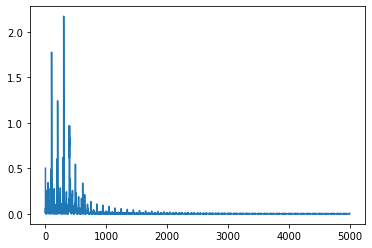

In [101]:
losses, accuracies = train_model(price_model, 
                                 LR=0.05, 
                                 n_epochs=50, 
                                 X_BATCH = np.split(X,100), 
                                 Y_BATCH = np.split(Y, 100)
                                )

plt.plot(losses)

In [102]:
out = price_model(X)
out_np = out.detach().numpy().squeeze()

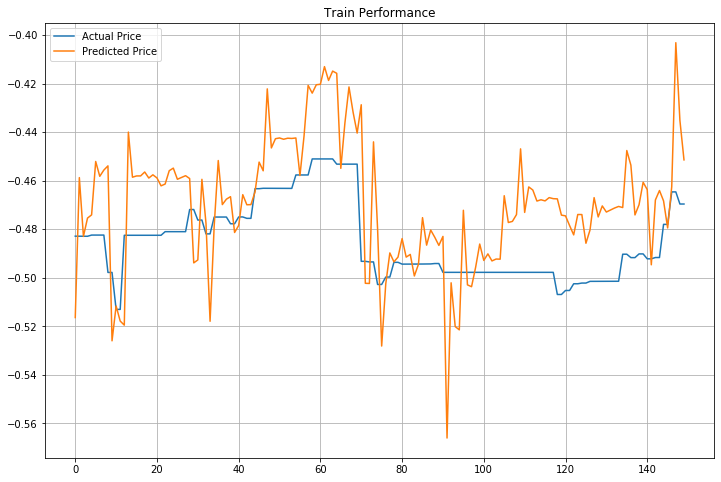

In [105]:
start = 5000
window = 150

fig, ax = plt.subplots(1,1, figsize = (12,8))
ax.plot(feature_norm[:,0][start + 100:start + 100 + window])
ax.plot(out_np[start:start + window])

ax.set_title('Train Performance')
ax.legend(['Actual Price','Predicted Price'])
ax.grid('on')

(49899,)
(49899,)


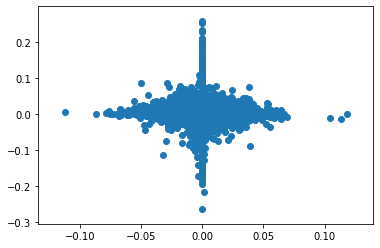

In [104]:
x = np.diff(feature_norm[:,0][100:])
y = np.diff(out_np[:])
plt.scatter(x,y)

print(x.shape)
print(y.shape)